In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import random
import re

/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

# Comparison on multiple datasets

In [3]:
import openml
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3

In [4]:
import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

In [5]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [6]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [7]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [8]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    #y_test_appended = np.concatenate([y_test,[1]])
    y_test_appended = clf.predict(X_test_appended)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [9]:
shap.initjs()

In [10]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [11]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [12]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
class CategoricalWrapper(BaseEstimator):
    def __init__(self, model, ohe_encoder = None, categorical_indicator=None, features = None, categories='auto'):
        if ohe_encoder is None:
            self.ohe_encoder = OneHotEncoder(categories=categories)
        else:
            self.ohe_encoder = ohe_encoder
            
        self.features = features
        self.categories=categories
        self.categorical_indicator=categorical_indicator
        self.ct = ColumnTransformer(  
            [("categorical", self.ohe_encoder, [f for f,c in zip(features,categorical_indicator) if c ] )],
        remainder='passthrough')
        
        self.model = model
    
    def fit(self, X,y):
        X_tr = self.ct.fit_transform(X)
        self.model.fit(X_tr,y)
        return self
    def predict(self,X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict(self.ct.transform(X))
    
    def predict_proba(self, X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict_proba(self.ct.transform(X))

In [13]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            if len((set(v1)|set(v2))) == 0:
                jackard = 0
            else:
                jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

In [14]:
def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        accuracy =  accuracy_score(dataset['class'],np.ones(len(dataset))*float(prediction))
        precision =  precision_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        recall =  recall_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        f1 =  f1_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        return 1,accuracy, precision, recall, f1
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f' and {i}{op}'.join(v))
    print(' and '.join(query))
    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

In [15]:
def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            if len(set(rule_1.keys())|set(rule_2.keys())) == 0:
                feature_jackart[i,ii] = 0
            else:
                feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired



In [16]:
def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Main comparison loop

## Benchmark, model agnostic

In [17]:
def predict_lux(model,X,y=None):
        if isinstance(X, pd.DataFrame):
            pass
        elif isinstance(X,np.ndarray):
            X = pd.DataFrame(X,columns=model.attributes_names)
        else:
            raise ValueError("Only 2D arrrays are allowed as an input")
            
        if y is None:
            y = pd.Series(np.arange(X.shape[0]),name='target_unused',index=X.index) # This is not used, but Data resered last 
                
        X=pd.concat((X,y),axis=1)
        XData = Data.parse_dataframe(X,'lux')
        return [int(f.get_name()) for f in model.predict(XData.get_instances())]

In [18]:
def generate_lore_dataset(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [19]:
suite = openml.study.get_suite(99)
print(suite)
tasks = suite.tasks
skip=True
num=0


use_suite = True

if not use_suite:
    all_datasets = openml.datasets.list_datasets(output_format='dataframe')
    classification_datasets = all_datasets[(all_datasets['NumberOfClasses']>1) & (all_datasets['NumberOfInstances']>500) & (all_datasets['NumberOfInstances']< 4000)& (all_datasets['NumberOfFeatures'] < 20)].drop_duplicates(subset=['name'])
    
    tasks = classification_datasets['did']

OpenML Benchmark Suite
ID..............: 99
Name............: OpenML-CC18 Curated Classification benchmark
Status..........: active
Main Entity Type: task
Study URL.......: https://www.openml.org/s/99
# of Data.......: 72
# of Tasks......: 72
Creator.........: https://www.openml.org/u/1
Upload Time.....: 2019-02-21 18:47:13


Processing kr-vs-kp
kr-vs-kp
Accuracy  model: 0.9899874843554443 for kr-vs-kp
Train size: 2397
----------- Model certainty for instance: 0.9999999851312218 ---------------
Neighbourhood size: 79
Average distace of neighbourhood: 10.31207560037465.
Neighbourhood size: 79
Average distace of neighbourhood: 7.952186898747143.


Permutation explainer: 550it [00:19, 16.09it/s]                         


Done 0.7285974499089253 upsampling
Done 0.9854280510018215 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1490 (0.6216103462661661)


Permutation explainer: 1492it [00:50, 24.98it/s]                          


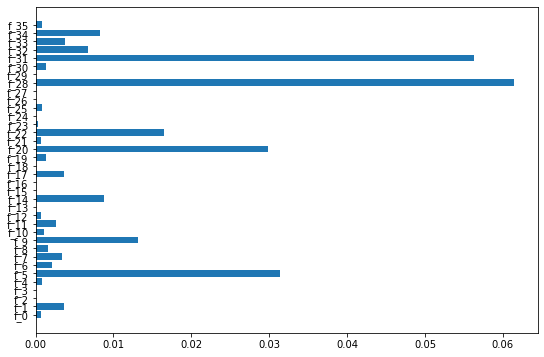

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.6216103462661661 samples from train set wiuth class balance: 0.7389261744966443


Permutation explainer: 900it [00:27, 23.47it/s]                         
Permutation explainer: 592it [00:20, 16.19it/s]                         
Permutation explainer: 440it [00:15, 11.35it/s]                         
Permutation explainer: 277it [00:10,  1.16it/s]                         


--- 212.1144278049469 seconds ---
IF f_28 <-3.8802707195281982 THEN class = 1 # 1.0



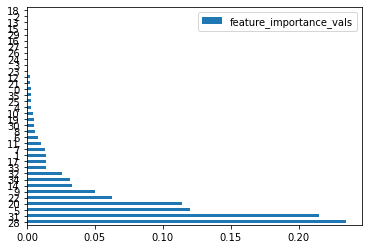

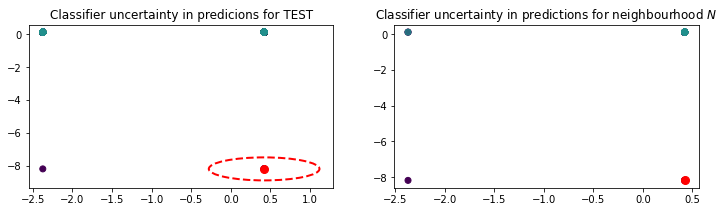

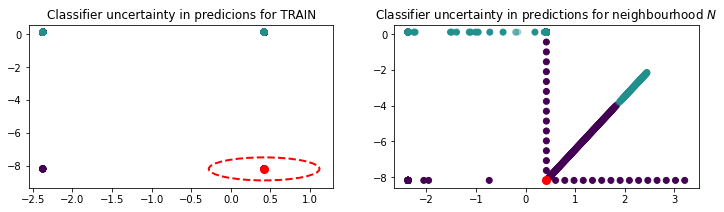

Fidelity  with shap: 1.0
f_28<-3.8802707195281982
f_28<-3.8802707195281982
SHAP coverage: nn: 0.0759493670886076 and local: 0.007509386733416771
Full rule: {'rule': {'f_28': ['< -3.8802707195281982']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX:0.234737280847484
Fidelity  EXPLAN: 0.8099173553719008
LORE expl e = {'f_20': ['>=0.4681033045053482'], 'f_34': ['>=0.5287914276123047'], 'f_32': ['>=-0.90831258893013'], 'f_5': ['>=0.8971133232116699'], 'f_9': ['>=-1.0712060630321503']}
f_20>=0.4681033045053482 and f_34>=0.5287914276123047 and f_32>=-0.90831258893013 and f_5>=0.8971133232116699 and f_9>=-1.0712060630321503
f_20>=0.4681033045053482 and f_34>=0.5287914276123047 and f_32>=-0.90831258893013 and f_5>=0.8971133232116699 and f_9>=-1.0712060630321503
Explan coverage: nn: 0.24050632911392406 and local: 0.07634543178973717
Full rule: {'rule': {'f_20': ['>= 0.4681033045053482'], 'f_34': ['>= 0.5287914276123047'], 'f_32': ['>= -0.90831258893013'], 'f_5': ['>= 0.8971133232116699'], 

Permutation explainer: 480it [00:13,  9.45it/s]                         


Done 0.5594989561586639 upsampling
Done 0.9791231732776617 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1216 (0.5073007926574885)


Permutation explainer: 1218it [00:38, 25.38it/s]                          


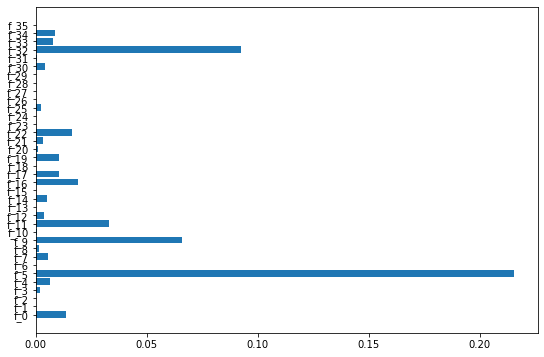

Fidelity  dectree: 0.9814814814814815
Lux w shap
In fact using: 0.5073007926574885 samples from train set wiuth class balance: 0.3963815789473684


Permutation explainer: 687it [00:17, 16.17it/s]                         
Permutation explainer: 621it [00:14, 12.83it/s]                         
Permutation explainer: 618it [00:14, 12.59it/s]                         
Permutation explainer: 615it [00:14, 12.08it/s]                         
Permutation explainer: 612it [00:14, 12.38it/s]                         
Permutation explainer: 531it [00:19, 14.80it/s]                         
Permutation explainer: 331it [00:12,  5.88it/s]                         
Permutation explainer: 304it [00:11,  3.83it/s]                         
Permutation explainer: 302it [00:11,  3.49it/s]                         


--- 291.5284080505371 seconds ---
IF f_16 <3.988329529762268 AND f_5 <-0.91124227643013 AND f_32 >= -1.1144636971748247 * f_9+0.22963575278772413 AND f_9 >=-0.25931382924318314 THEN class = 0 # 0.998371335504886



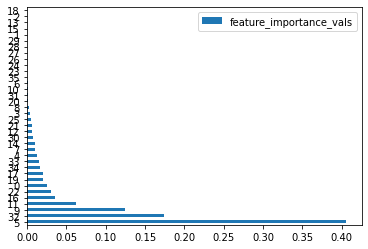

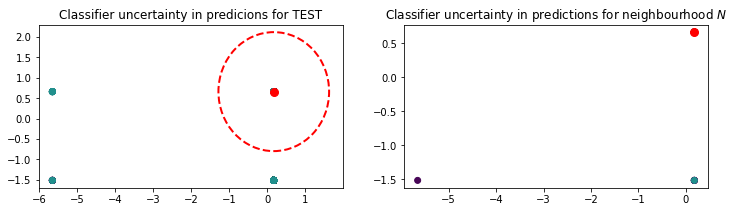

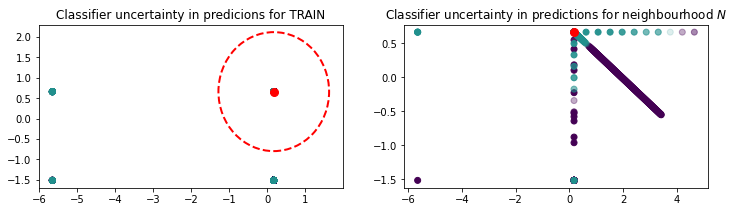

Fidelity  with shap: 0.9514563106796116
f_16<3.988329529762268 and f_5<-0.91124227643013 and f_32>= -1.1144636971748247 * f_9+0.22963575278772413 and f_9>=-0.25931382924318314
f_16<3.988329529762268 and f_5<-0.91124227643013 and f_32>= -1.1144636971748247 * f_9+0.22963575278772413 and f_9>=-0.25931382924318314
SHAP coverage: nn: 0.4430379746835443 and local: 0.21401752190237797
Full rule: {'rule': {'f_16': ['< 3.988329529762268'], 'f_5': ['< -0.91124227643013'], 'f_32': ['>= -1.1144636971748247 * f_9+0.22963575278772413'], 'f_9': ['>= -0.25931382924318314']}, 'prediction': '0', 'confidence': 0.998371335504886}
SHAPGAIN LUX:0.1848705710959175
Fidelity  EXPLAN: 0.9333333333333333
LORE expl e = {'f_14': ['>=-1.258307620882988'], 'f_20': ['>=0.4442529082298279'], 'f_34': ['>=1.6497339010238647'], 'f_5': ['<-0.07783165574073792'], 'f_32': ['>=-1.0658874809741974'], 'f_8': ['>=-0.24618637561798096'], 'f_9': ['>=-0.6192316859960556']}
f_14>=-1.258307620882988 and f_20>=0.4442529082298279 and 

Permutation explainer: 386it [00:11,  4.97it/s]                         


Done 0.522077922077922 upsampling
Done 0.9376623376623376 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 947 (0.3950771798080934)


Permutation explainer: 949it [00:32, 21.79it/s]                         


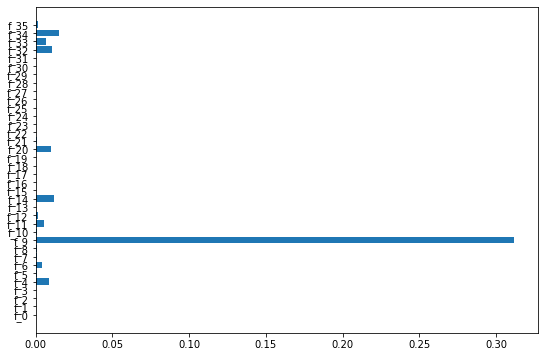

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.3950771798080934 samples from train set wiuth class balance: 0.6462513199577613


Permutation explainer: 566it [00:16, 14.03it/s]                         
Permutation explainer: 544it [00:17, 13.88it/s]                         
Permutation explainer: 383it [00:15,  9.77it/s]                         
Permutation explainer: 341it [00:13,  6.82it/s]                         


--- 178.26501178741455 seconds ---
IF f_20 >= 0.5877062044176354 * f_32+-0.7836821552470317 AND f_9 <-1.1551254987716675 THEN class = 1 # 1.0



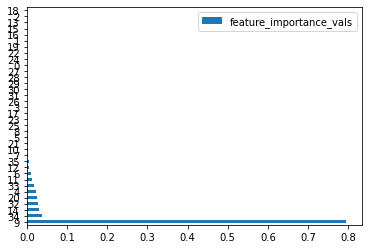

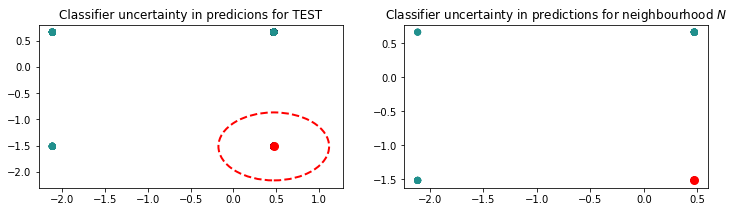

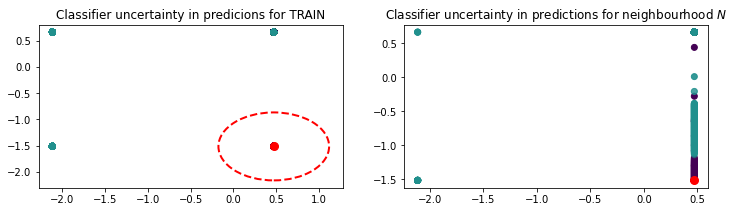

Fidelity  with shap: 0.9873417721518987
f_20>= 0.5877062044176354 * f_32+-0.7836821552470317 and f_9<-1.1551254987716675
f_20>= 0.5877062044176354 * f_32+-0.7836821552470317 and f_9<-1.1551254987716675
SHAP coverage: nn: 0.43037974683544306 and local: 0.22403003754693368
Full rule: {'rule': {'f_20': ['>= 0.5877062044176354 * f_32+-0.7836821552470317'], 'f_9': ['< -1.1551254987716675']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX:0.4096658181057546
Fidelity  EXPLAN: 0.8571428571428571
LORE expl e = {'f_9': ['== -1.5137543100601094']}
f_9== -1.5137543100601094
f_9== -1.5137543100601094
Explan coverage: nn: 0.5443037974683544 and local: 0.29912390488110135
Full rule: {'rule': {'f_9': ['== -1.5137543100601094']}, 'prediction': '1', 'confidence': 0.9957446808510639}
SHAPGAIN explan:0.7938605819462562
Fidelity  LORE: 0.975
LORE expl e = {'f_20': ['>=-0.39488064777106047'], 'f_9': ['<-0.40023043751716614']}
Ats lore: ['f_20', 'f_9']
f_20>=-0.39488064777106047 and f_9<-0.40023043751716

Permutation explainer: 432it [00:14,  8.74it/s]                         


Done 0.5962877030162413 upsampling
Done 0.9211136890951276 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1085 (0.4526491447642887)


Permutation explainer: 1087it [00:37, 22.76it/s]                          


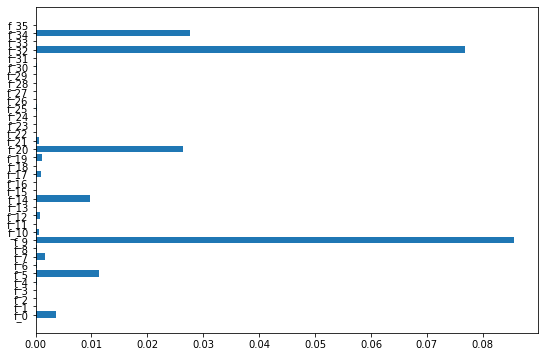

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.4526491447642887 samples from train set wiuth class balance: 0.7926267281105991


Permutation explainer: 794it [00:27, 20.22it/s]                         
Permutation explainer: 783it [00:29, 18.78it/s]                         


--- 172.3164553642273 seconds ---
IF f_20 >=-0.8210033923387527 AND f_32 <-0.10573893412947655 THEN class = 1 # 1.0



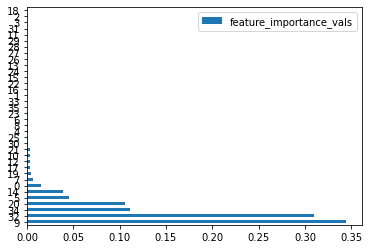

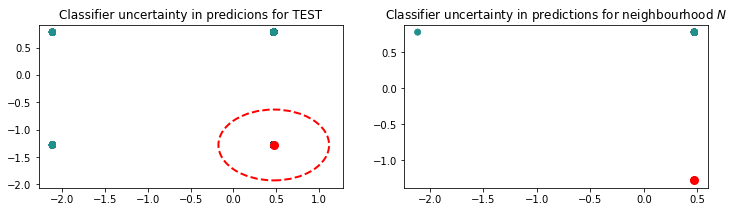

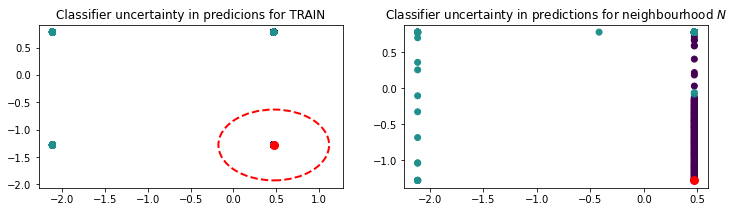

Fidelity  with shap: 1.0
f_20>=-0.8210033923387527 and f_32<-0.10573893412947655
f_20>=-0.8210033923387527 and f_32<-0.10573893412947655
SHAP coverage: nn: 0.4936708860759494 and local: 0.2978723404255319
Full rule: {'rule': {'f_20': ['>= -0.8210033923387527'], 'f_32': ['< -0.10573893412947655']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX:0.20753950389984593
Fidelity  EXPLAN: 0.9473684210526316
LORE expl e = {'f_9': ['== -1.5137543100601094']}
f_9== -1.5137543100601094
f_9== -1.5137543100601094
Explan coverage: nn: 0.5189873417721519 and local: 0.29912390488110135
Full rule: {'rule': {'f_9': ['== -1.5137543100601094']}, 'prediction': '1', 'confidence': 0.9966777408637875}
SHAPGAIN explan:0.3440427621068763
Fidelity  LORE: 0.9473684210526316
LORE expl e = {'f_20': ['>=-1.0592222809791565'], 'f_9': ['<-0.28235233575105667']}
Ats lore: ['f_20', 'f_9']
f_20>=-1.0592222809791565 and f_9<-0.28235233575105667
f_20>=-1.0592222809791565 and f_9<-0.28235233575105667
LORE coverage: nn: 0

Permutation explainer: 386it [00:12,  5.25it/s]                         


Done 0.5792207792207792 upsampling
Done 0.9376623376623376 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 969 (0.40425531914893614)


Permutation explainer: 971it [00:33, 22.54it/s]                         


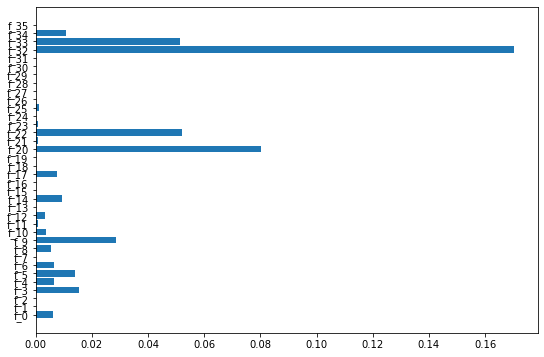

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.40425531914893614 samples from train set wiuth class balance: 0.6026831785345718


Permutation explainer: 550it [00:14, 11.13it/s]                         
Permutation explainer: 487it [00:13,  8.49it/s]                         
Permutation explainer: 482it [00:12,  7.79it/s]                         
Permutation explainer: 421it [00:16, 10.89it/s]                         
Permutation explainer: 345it [00:14,  7.91it/s]                         
Permutation explainer: 293it [00:11,  3.72it/s]                         
Permutation explainer: 277it [00:11,  3.85it/s]                         


--- 194.1376874446869 seconds ---
IF f_20 >= 0.9558324909241591 * f_33+-0.07962165920800665 AND f_9 < 0.5800429908821769 * f_5+2.3135035640779176 AND f_32 <-1.0786890387535095 THEN class = 1 # 1.0



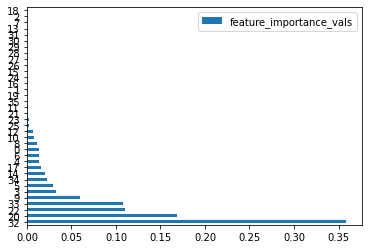

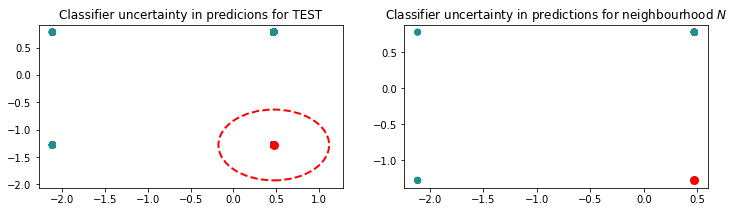

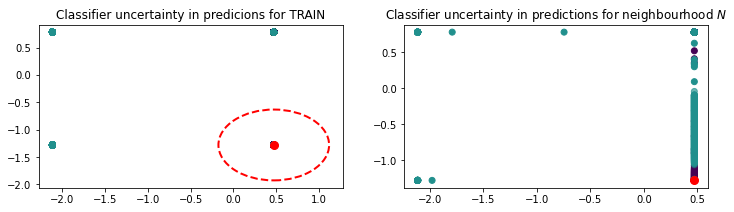

Fidelity  with shap: 0.9803921568627451
f_20>= 0.9558324909241591 * f_33+-0.07962165920800665 and f_9< 0.5800429908821769 * f_5+2.3135035640779176 and f_32<-1.0786890387535095
f_20>= 0.9558324909241591 * f_33+-0.07962165920800665 and f_9< 0.5800429908821769 * f_5+2.3135035640779176 and f_32<-1.0786890387535095
SHAP coverage: nn: 0.3924050632911392 and local: 0.18272841051314143
Full rule: {'rule': {'f_20': ['>= 0.9558324909241591 * f_33+-0.07962165920800665'], 'f_9': ['< 0.5800429908821769 * f_5+2.3135035640779176'], 'f_32': ['< -1.0786890387535095']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX:0.19576373164619484
Fidelity  EXPLAN: 1.0
LORE expl e = {'f_14': ['<-0.11566990613937378'], 'f_20': ['>=0.44120027124881744'], 'f_32': ['<-1.2766451835632324'], 'f_33': ['<0.26476386189460754'], 'f_9': ['>=-0.4265725910663605']}
f_14<-0.11566990613937378 and f_20>=0.44120027124881744 and f_32<-1.2766451835632324 and f_33<0.26476386189460754 and f_9>=-0.4265725910663605
f_14<-0.1156699061

Permutation explainer: 372it [00:13,  6.89it/s]                         


Done 0.6361185983827493 upsampling
Done 0.9730458221024259 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 968 (0.40383813099707966)


Permutation explainer: 970it [00:36, 20.83it/s]                         


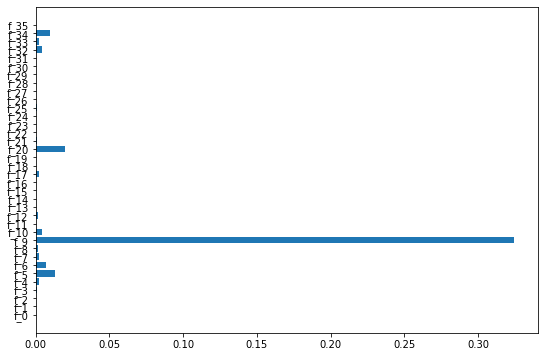

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.40383813099707966 samples from train set wiuth class balance: 0.6683884297520661


Permutation explainer: 613it [00:20, 16.57it/s]                         
Permutation explainer: 588it [00:21, 15.94it/s]                         
Permutation explainer: 586it [00:21, 15.75it/s]                         
Permutation explainer: 357it [00:15,  9.19it/s]                         
Permutation explainer: 308it [00:14,  7.31it/s]                         
Permutation explainer: 299it [00:14,  6.83it/s]                         


--- 210.54425835609436 seconds ---
IF f_20 >=-0.8210033923387527 AND f_9 <-0.9012988209724426 AND f_32 <2.5334694385528564 THEN class = 1 # 1.0



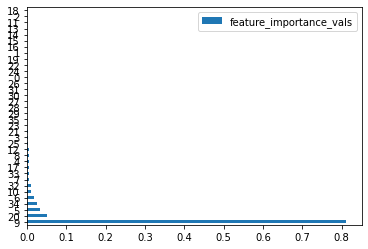

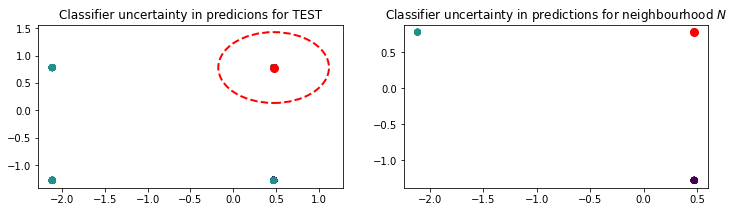

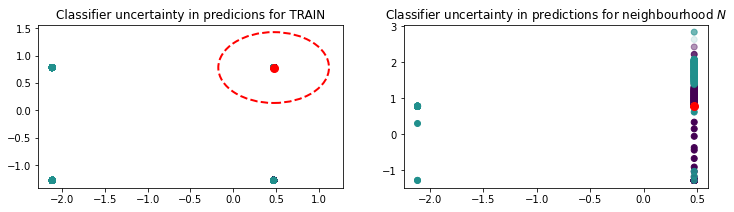

Fidelity  with shap: 0.98989898989899
f_20>=-0.8210033923387527 and f_9<-0.9012988209724426 and f_32<2.5334694385528564
f_20>=-0.8210033923387527 and f_9<-0.9012988209724426 and f_32<2.5334694385528564
SHAP coverage: nn: 0.43037974683544306 and local: 0.22403003754693368
Full rule: {'rule': {'f_20': ['>= -0.8210033923387527'], 'f_9': ['< -0.9012988209724426'], 'f_32': ['< 2.5334694385528564']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX:0.2902192704425029
Fidelity  EXPLAN: 0.8064516129032258
LORE expl e = {'f_14': ['>=-1.258307620882988'], 'f_20': ['== 0.4728461281954939'], 'f_30': ['== 0.4634082912440848'], 'f_31': ['== 0.24068202771308894']}
f_14>=-1.258307620882988 and f_20== 0.4728461281954939 and f_30== 0.4634082912440848 and f_31== 0.24068202771308894
f_14>=-1.258307620882988 and f_20== 0.4728461281954939 and f_30== 0.4634082912440848 and f_31== 0.24068202771308894
Explan coverage: nn: 0.9240506329113924 and local: 0.6145181476846058
Full rule: {'rule': {'f_14': ['>= -1.2

Permutation explainer: 476it [00:15, 10.41it/s]                         


Done 0.6505263157894737 upsampling
Done 0.9873684210526316 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1253 (0.5227367542761786)


Permutation explainer: 1255it [00:39, 25.48it/s]                          


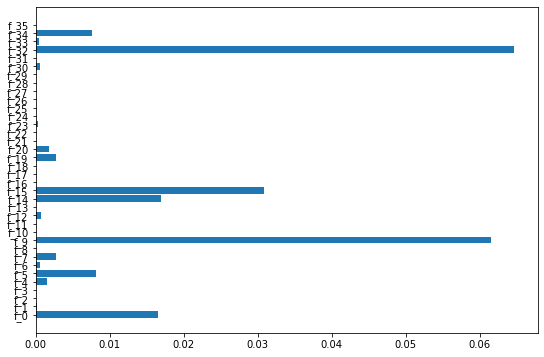

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.5227367542761786 samples from train set wiuth class balance: 0.810853950518755


Permutation explainer: 929it [00:28, 23.18it/s]                         
Permutation explainer: 916it [00:28, 22.85it/s]                         


--- 183.90141654014587 seconds ---
IF f_20 >=-0.0847816914319992 AND f_9 <0.05996726732701063 THEN class = 1 # 1.0



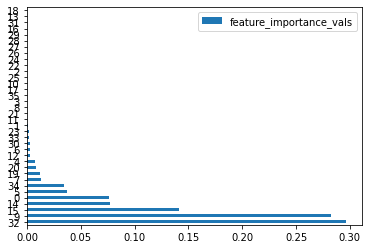

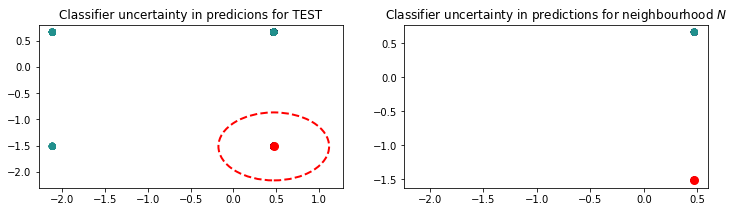

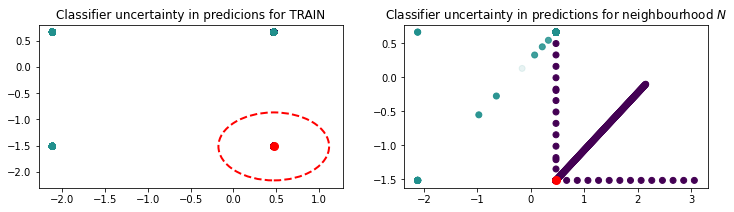

Fidelity  with shap: 1.0
f_20>=-0.0847816914319992 and f_9<0.05996726732701063
f_20>=-0.0847816914319992 and f_9<0.05996726732701063
SHAP coverage: nn: 0.5443037974683544 and local: 0.22403003754693368
Full rule: {'rule': {'f_20': ['>= -0.0847816914319992'], 'f_9': ['< 0.05996726732701063']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX:0.14526670231969166
Fidelity  EXPLAN: 0.8888888888888888
LORE expl e = {'f_20': ['>=0.4618164896965027'], 'f_9': ['<-0.4265725910663605']}
f_20>=0.4618164896965027 and f_9<-0.4265725910663605
f_20>=0.4618164896965027 and f_9<-0.4265725910663605
Explan coverage: nn: 0.5443037974683544 and local: 0.22403003754693368
Full rule: {'rule': {'f_20': ['>= 0.4618164896965027'], 'f_9': ['< -0.4265725910663605']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN explan:0.14526670231969166
Fidelity  LORE: 0.9481481481481481
LORE expl e = {'f_20': ['>=-2.0554736852645874'], 'f_9': ['<0.3725908547639847']}
Ats lore: ['f_20', 'f_9']
f_20>=-2.0554736852645874 and f

Permutation explainer: 424it [00:14,  8.97it/s]                         


Done 0.5626477541371159 upsampling
Done 0.9385342789598109 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1058 (0.44138506466416355)


Permutation explainer: 1060it [00:37, 22.33it/s]                          


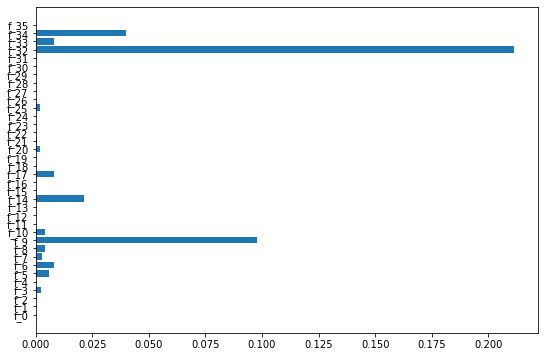

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.44138506466416355 samples from train set wiuth class balance: 0.3771266540642722


Permutation explainer: 373it [00:15,  9.37it/s]                         
Permutation explainer: 334it [00:13,  7.60it/s]                         
Permutation explainer: 329it [00:14,  7.96it/s]                         
Permutation explainer: 324it [00:14,  7.67it/s]                         
Permutation explainer: 687it [00:20, 17.16it/s]                         
Permutation explainer: 612it [00:18, 15.47it/s]                         
Permutation explainer: 607it [00:18, 15.35it/s]                         


--- 239.86256909370422 seconds ---
IF f_9 >= 0.7767665890848681 * f_34+-0.17396566428034738 AND f_9 >= -0.6416568899228902 * f_14+-0.6116507363649072 AND f_32 >=0.4916839748620987 THEN class = 0 # 1.0



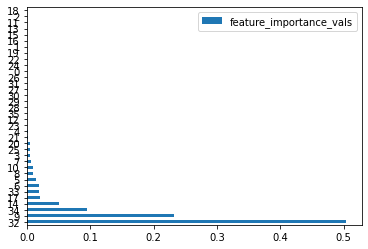

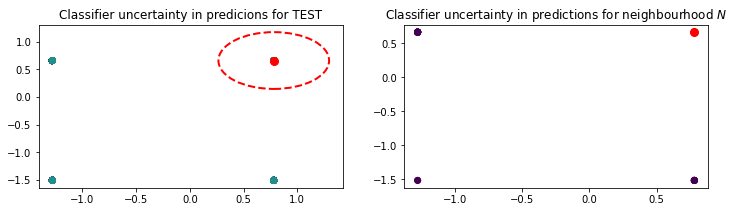

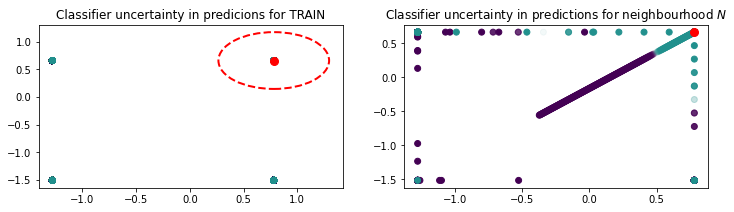

Fidelity  with shap: 1.0
f_9>= 0.7767665890848681 * f_34+-0.17396566428034738 and f_9>= -0.6416568899228902 * f_14+-0.6116507363649072 and f_32>=0.4916839748620987
f_9>= 0.7767665890848681 * f_34+-0.17396566428034738 and f_9>= -0.6416568899228902 * f_14+-0.6116507363649072 and f_32>=0.4916839748620987
SHAP coverage: nn: 0.569620253164557 and local: 0.2828535669586984
Full rule: {'rule': {'f_9': ['>= 0.7767665890848681 * f_34+-0.17396566428034738', '>= -0.6416568899228902 * f_14+-0.6116507363649072'], 'f_32': ['>= 0.4916839748620987']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.36802333520040775
Fidelity  EXPLAN: 1.0
LORE expl e = {'f_14': ['>=-1.258307620882988'], 'f_34': ['<0.5287914276123047'], 'f_32': ['>=0.7428940236568451'], 'f_9': ['>=0.5915096998214722']}
f_14>=-1.258307620882988 and f_34<0.5287914276123047 and f_32>=0.7428940236568451 and f_9>=0.5915096998214722
f_14>=-1.258307620882988 and f_34<0.5287914276123047 and f_32>=0.7428940236568451 and f_9>=0.5915096998214

Permutation explainer: 406it [00:13,  7.79it/s]                         


Done 0.671604938271605 upsampling
Done 0.980246913580247 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1074 (0.44806007509386736)


Permutation explainer: 1076it [00:37, 22.57it/s]                          


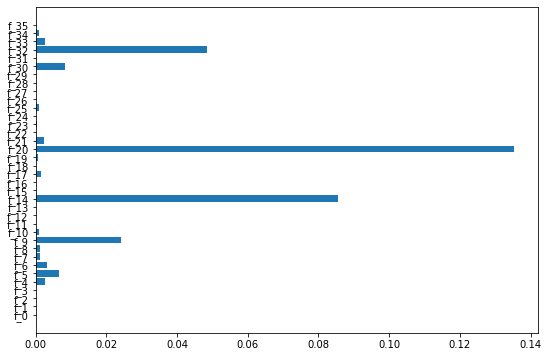

Fidelity  dectree: 0.9921259842519685
Lux w shap
In fact using: 0.44806007509386736 samples from train set wiuth class balance: 0.3202979515828678


Permutation explainer: 625it [00:19, 16.78it/s]                         
Permutation explainer: 451it [00:17, 11.73it/s]                         


--- 167.243168592453 seconds ---
IF f_20 <-1.2874281406402588 THEN class = 0 # 1.0



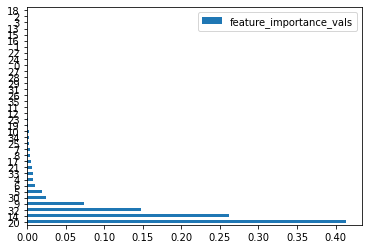

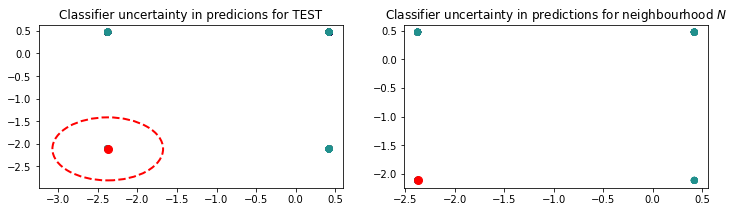

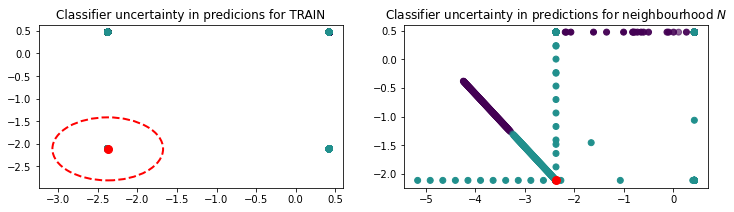

Fidelity  with shap: 0.9843749999999999
f_20<-1.2874281406402588
f_20<-1.2874281406402588
SHAP coverage: nn: 0.31645569620253167 and local: 0.16896120150187735
Full rule: {'rule': {'f_20': ['< -1.2874281406402588']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.41321043851039435
Fidelity  EXPLAN: 0.5681818181818182
LORE expl e = {'f_20': ['== -2.1148528884360096'], 'f_9': ['>=-1.499921202659607']}
f_20== -2.1148528884360096 and f_9>=-1.499921202659607
f_20== -2.1148528884360096 and f_9>=-1.499921202659607
Explan coverage: nn: 0.20253164556962025 and local: 0.09386733416770963
Full rule: {'rule': {'f_20': ['== -2.1148528884360096'], 'f_9': ['>= -1.499921202659607']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN explan:0.2433412379789594
Fidelity  LORE: 0.8750000000000001
LORE expl e = {'f_20': ['<0.1758282110095024']}
Ats lore: ['f_20']
f_20<0.1758282110095024
f_20<0.1758282110095024
LORE coverage: nn: 0.31645569620253167 and local: 0.16896120150187735
Full rule: {'rule': {'f_

Permutation explainer: 386it [00:11,  5.00it/s]                         


Done 0.522077922077922 upsampling
Done 0.9376623376623376 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 947 (0.3950771798080934)


Permutation explainer: 949it [00:37, 19.83it/s]                         


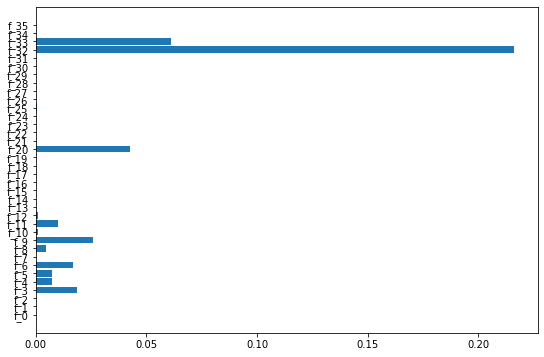

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.3950771798080934 samples from train set wiuth class balance: 0.5923970432946146


Permutation explainer: 554it [00:15, 11.72it/s]                         
Permutation explainer: 502it [00:15, 10.80it/s]                         
Permutation explainer: 494it [00:15, 10.83it/s]                         
Permutation explainer: 491it [00:16, 11.33it/s]                         
Permutation explainer: 395it [00:14,  9.58it/s]                         
Permutation explainer: 339it [00:12,  6.24it/s]                         


--- 214.70878720283508 seconds ---
IF f_20 >= 0.9397598219615186 * f_33+-0.0700227184908551 AND f_32 <-1.1429288983345032 AND f_6 <2.3168102502822876 AND f_9 < -0.21561123556433076 * f_3+1.254941893837059 THEN class = 1 # 0.9979591836734694



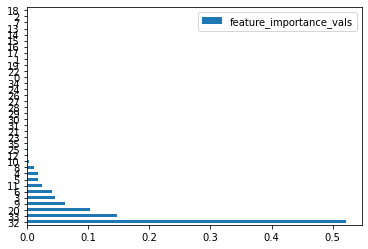

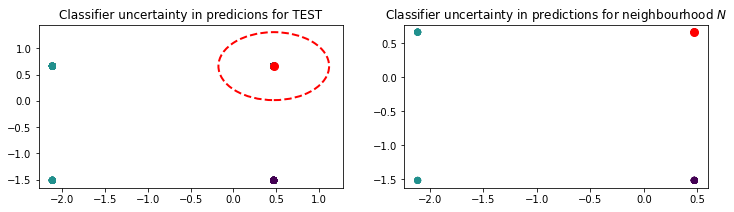

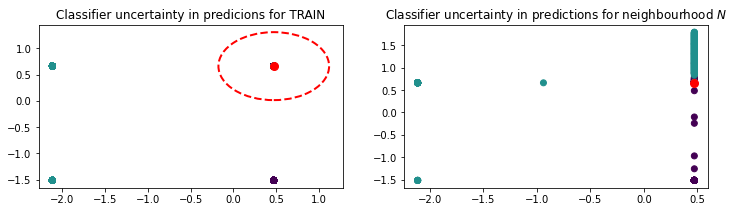

Fidelity  with shap: 0.9777777777777777
f_20>= 0.9397598219615186 * f_33+-0.0700227184908551 and f_32<-1.1429288983345032 and f_6<2.3168102502822876 and f_9< -0.21561123556433076 * f_3+1.254941893837059
f_20>= 0.9397598219615186 * f_33+-0.0700227184908551 and f_32<-1.1429288983345032 and f_6<2.3168102502822876 and f_9< -0.21561123556433076 * f_3+1.254941893837059
SHAP coverage: nn: 0.4430379746835443 and local: 0.18272841051314143
Full rule: {'rule': {'f_20': ['>= 0.9397598219615186 * f_33+-0.0700227184908551'], 'f_32': ['< -1.1429288983345032'], 'f_6': ['< 2.3168102502822876'], 'f_9': ['< -0.21561123556433076 * f_3+1.254941893837059']}, 'prediction': '1', 'confidence': 0.9979591836734694}
SHAPGAIN LUX:0.1819478258727235
Fidelity  EXPLAN: 0.8712871287128713
LORE expl e = {'f_14': ['<0.9513358622789383'], 'f_25': ['>=0.41936343908309937'], 'f_32': ['<-1.0701810419559479'], 'f_17': ['<0.4035385251045227'], 'f_33': ['<0.26476386189460754']}
f_14<0.9513358622789383 and f_25>=0.419363439083

Permutation explainer: 436it [00:12,  6.20it/s]                         


Done 0.4459770114942529 upsampling
Done 0.9954022988505747 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1062 (0.4430538172715895)


Permutation explainer: 1064it [00:57, 16.08it/s]                          


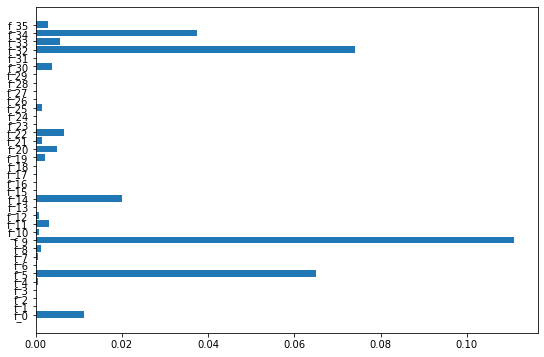

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.4430538172715895 samples from train set wiuth class balance: 0.3182674199623352


Permutation explainer: 237it [00:16,  5.35it/s]                         
Permutation explainer: 233it [00:18,  7.24it/s]                         
Permutation explainer: 230it [00:20,  6.41it/s]                         
Permutation explainer: 122it [00:11,  1.23it/s]                         
Permutation explainer: 827it [00:40, 14.49it/s]                         
Permutation explainer: 740it [00:35, 16.24it/s]                         
Permutation explainer: 611it [00:31, 14.60it/s]                         


--- 313.3810918331146 seconds ---
IF f_32 >=0.35057778656482697 AND f_9 >=0.27322258055210114 AND f_5 <0.8416072726249695 THEN class = 0 # 1.0



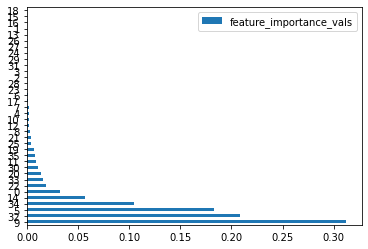

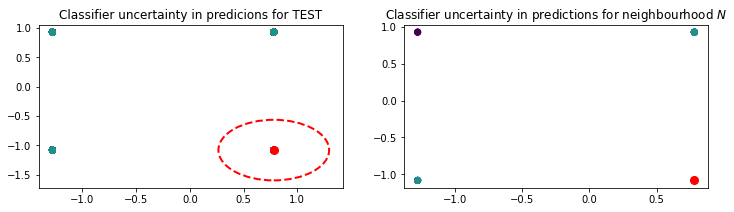

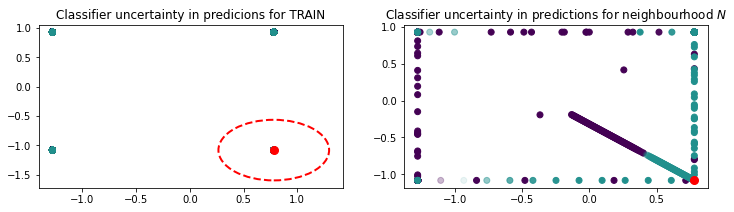

Fidelity  with shap: 0.9532710280373832
f_32>=0.35057778656482697 and f_9>=0.27322258055210114 and f_5<0.8416072726249695
f_32>=0.35057778656482697 and f_9>=0.27322258055210114 and f_5<0.8416072726249695
SHAP coverage: nn: 0.43037974683544306 and local: 0.21401752190237797
Full rule: {'rule': {'f_32': ['>= 0.35057778656482697'], 'f_9': ['>= 0.27322258055210114'], 'f_5': ['< 0.8416072726249695']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.23427359400159684
Fidelity  EXPLAN: 0.9482758620689654
LORE expl e = {'f_34': ['<-0.4459061920642853'], 'f_9': ['>=-0.4265725910663605'], 'f_32': ['>=0.7415728569030762']}
f_34<-0.4459061920642853 and f_9>=-0.4265725910663605 and f_32>=0.7415728569030762
f_34<-0.4459061920642853 and f_9>=-0.4265725910663605 and f_32>=0.7415728569030762
Explan coverage: nn: 0.4936708860759494 and local: 0.31289111389236546
Full rule: {'rule': {'f_34': ['< -0.4459061920642853'], 'f_9': ['>= -0.4265725910663605'], 'f_32': ['>= 0.7415728569030762']}, 'prediction

Permutation explainer: 422it [00:16, 11.99it/s]                         


Done 0.6460807600950119 upsampling
Done 0.9429928741092637 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1090 (0.4547350855235711)


Permutation explainer: 1092it [01:03, 14.64it/s]                          


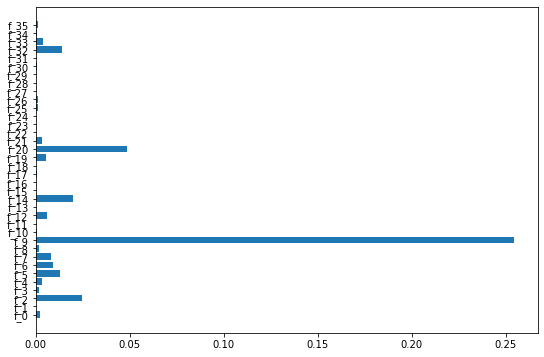

Fidelity  dectree: 0.9803921568627451
Lux w shap
In fact using: 0.4547350855235711 samples from train set wiuth class balance: 0.6302752293577981


Permutation explainer: 637it [00:25, 15.36it/s]                         
Permutation explainer: 629it [00:29, 16.56it/s]                         
Permutation explainer: 455it [00:35,  9.53it/s]                         
Permutation explainer: 424it [00:23, 11.25it/s]                         
Permutation explainer: 192it [00:16,  4.34it/s]                         
Permutation explainer: 186it [00:10,  5.03s/it]                 
Permutation explainer: 233it [00:10,  3.36s/it]                 
Permutation explainer: 225it [00:14,  4.21it/s]                         


--- 287.56652784347534 seconds ---
IF f_20 >=-1.526739478111267 AND f_9 <-1.093805193901062 THEN class = 1 # 1.0



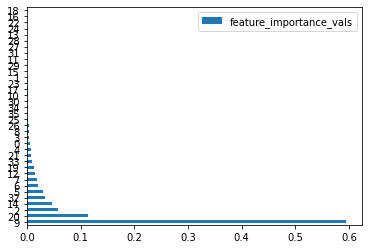

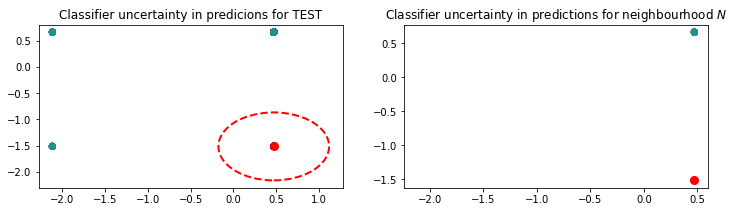

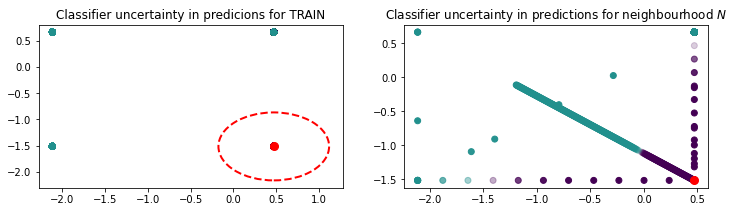

Fidelity  with shap: 0.9902912621359222
f_20>=-1.526739478111267 and f_9<-1.093805193901062
f_20>=-1.526739478111267 and f_9<-1.093805193901062
SHAP coverage: nn: 0.46835443037974683 and local: 0.22403003754693368
Full rule: {'rule': {'f_20': ['>= -1.526739478111267'], 'f_9': ['< -1.093805193901062']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX:0.3534964219816299
Fidelity  EXPLAN: 0.9387755102040816
LORE expl e = {'f_17': ['<1.4481239318847656'], 'f_20': ['== 0.4728461281954939'], 'f_9': ['<0.568154901266098']}
f_17<1.4481239318847656 and f_20== 0.4728461281954939 and f_9<0.568154901266098
f_17<1.4481239318847656 and f_20== 0.4728461281954939 and f_9<0.568154901266098
Explan coverage: nn: 0.35443037974683544 and local: 0.17271589486858574
Full rule: {'rule': {'f_17': ['< 1.4481239318847656'], 'f_20': ['== 0.4728461281954939'], 'f_9': ['< 0.568154901266098']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN explan:0.2356642813210866
Fidelity  LORE: 0.8444444444444443
LORE expl e 

Permutation explainer: 362it [00:10,  1.11it/s]                         


Done 0.5623268698060941 upsampling
Done 1.0 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 925 (0.3858990404672507)


Permutation explainer: 927it [01:02, 12.62it/s]                         


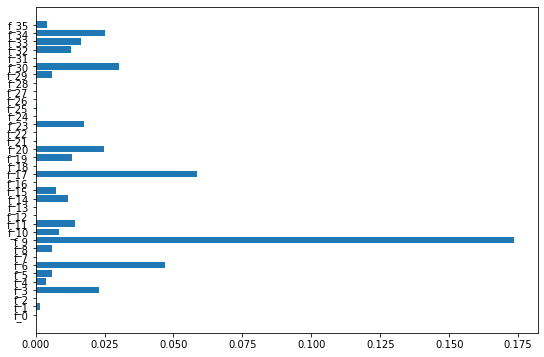

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.3858990404672507 samples from train set wiuth class balance: 0.41945945945945945


Permutation explainer: 325it [00:15,  6.18it/s]                         
Permutation explainer: 293it [00:23,  8.52it/s]                         
Permutation explainer: 233it [00:19,  7.21it/s]                         
Permutation explainer: 602it [00:19, 11.71it/s]                         
Permutation explainer: 543it [00:22, 14.07it/s]                         
Permutation explainer: 505it [00:25, 13.63it/s]                         
Permutation explainer: 494it [00:16, 10.04it/s]                         
Permutation explainer: 491it [00:23, 11.27it/s]                         
Permutation explainer: 488it [00:20, 15.66it/s]                         
Permutation explainer: 485it [00:21,  7.52it/s]                         
Permutation explainer: 478it [00:26, 11.67it/s]                         
Permutation explainer: 476it [00:11,  6.52it/s]                         


--- 383.67088508605957 seconds ---
IF f_14 >=-1.8107184171676636 AND f_30 <1.6430079340934753 AND f_3 >=-2.821438193321228 AND f_32 >=-2.4130061864852905 AND f_32 >= 5.206480589979038 * f_34+-6.161131316555247 AND f_17 >= -0.5685206826350032 * f_32+-0.7613430060812292 AND f_15 >=-2.0939494147896767 AND f_6 >=-0.38178329169750214 AND f_9 >=0.5431573987007141 THEN class = 0 # 0.9957894736842106



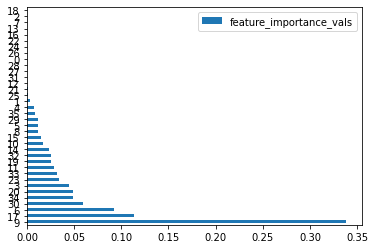

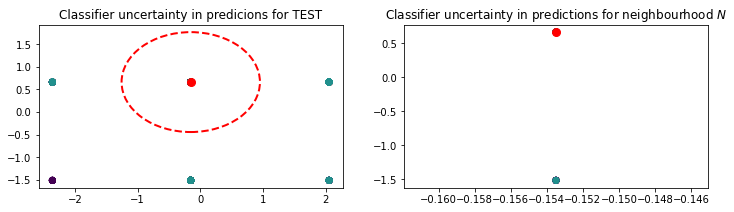

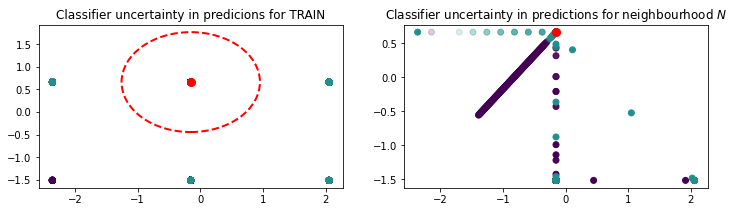

Fidelity  with shap: 0.9896907216494846
f_14>=-1.8107184171676636 and f_30<1.6430079340934753 and f_3>=-2.821438193321228 and f_32>=-2.4130061864852905 and f_32>= 5.206480589979038 * f_34+-6.161131316555247 and f_17>= -0.5685206826350032 * f_32+-0.7613430060812292 and f_15>=-2.0939494147896767 and f_6>=-0.38178329169750214 and f_9>=0.5431573987007141
f_14>=-1.8107184171676636 and f_30<1.6430079340934753 and f_3>=-2.821438193321228 and f_32>=-2.4130061864852905 and f_32>= 5.206480589979038 * f_34+-6.161131316555247 and f_17>= -0.5685206826350032 * f_32+-0.7613430060812292 and f_15>=-2.0939494147896767 and f_6>=-0.38178329169750214 and f_9>=0.5431573987007141
SHAP coverage: nn: 0.5189873417721519 and local: 0.2165206508135169
Full rule: {'rule': {'f_14': ['>= -1.8107184171676636'], 'f_30': ['< 1.6430079340934753'], 'f_3': ['>= -2.821438193321228'], 'f_32': ['>= 5.206480589979038 * f_34+-6.161131316555247', '>= -2.4130061864852905'], 'f_17': ['>= -0.5685206826350032 * f_32+-0.761343006081

Permutation explainer: 440it [00:21, 12.50it/s]                         


Done 0.5945330296127562 upsampling
Done 0.9863325740318907 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1133 (0.47267417605340006)


Permutation explainer: 1135it [01:16, 13.39it/s]                          


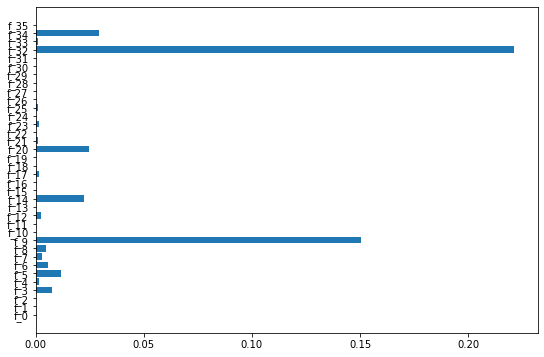

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.47267417605340006 samples from train set wiuth class balance: 0.35834068843777583


Permutation explainer: 288it [00:24,  6.05it/s]                         
Permutation explainer: 243it [00:20,  7.75it/s]                         
Permutation explainer: 847it [00:47, 13.32it/s]                         
Permutation explainer: 154it [00:11,  1.27it/s]                         
Permutation explainer: 115it [00:11,  1.02s/it]                         
Permutation explainer: 694it [00:45, 12.87it/s]                         
Permutation explainer: 636it [00:36, 13.11it/s]                         


--- 319.8630793094635 seconds ---
IF f_32 >=-0.5802814960479736 AND f_9 >=0.2618933171033859 AND f_5 <0.9180879890918732 THEN class = 0 # 1.0



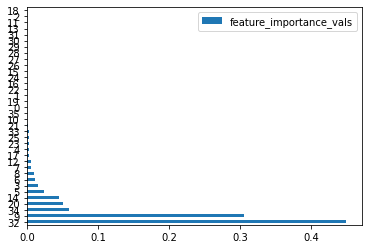

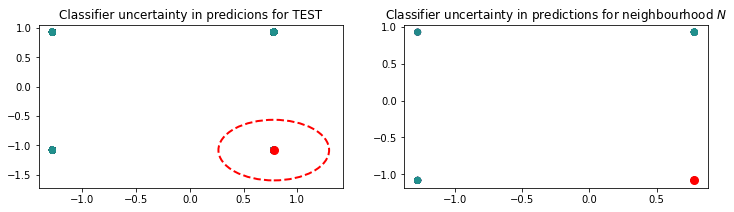

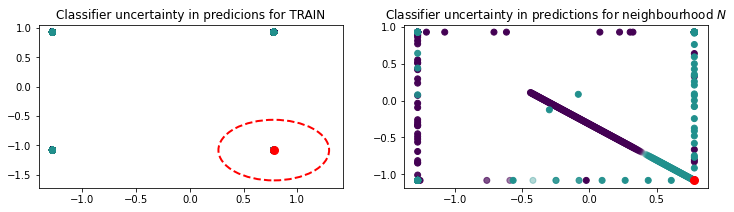

Fidelity  with shap: 1.0
f_32>=-0.5802814960479736 and f_9>=0.2618933171033859 and f_5<0.9180879890918732
f_32>=-0.5802814960479736 and f_9>=0.2618933171033859 and f_5<0.9180879890918732
SHAP coverage: nn: 0.379746835443038 and local: 0.21401752190237797
Full rule: {'rule': {'f_32': ['>= -0.5802814960479736'], 'f_9': ['>= 0.2618933171033859'], 'f_5': ['< 0.9180879890918732']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.2595404131810092
Fidelity  EXPLAN: 0.9719626168224299
LORE expl e = {'f_14': ['>=-2.327746033668518'], 'f_34': ['<1.6069450378417969'], 'f_32': ['>=-1.0105838477611542'], 'f_9': ['== 0.6606091843003894']}
f_14>=-2.327746033668518 and f_34<1.6069450378417969 and f_32>=-1.0105838477611542 and f_9== 0.6606091843003894
f_14>=-2.327746033668518 and f_34<1.6069450378417969 and f_32>=-1.0105838477611542 and f_9== 0.6606091843003894
Explan coverage: nn: 0.5316455696202531 and local: 0.2828535669586984
Full rule: {'rule': {'f_14': ['>= -2.327746033668518'], 'f_34': ['< 

Permutation explainer: 404it [00:30,  9.12it/s]                         


Done 0.5583126550868487 upsampling
Done 0.9851116625310173 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1025 (0.42761785565289945)


Permutation explainer: 1027it [01:09, 13.53it/s]                          


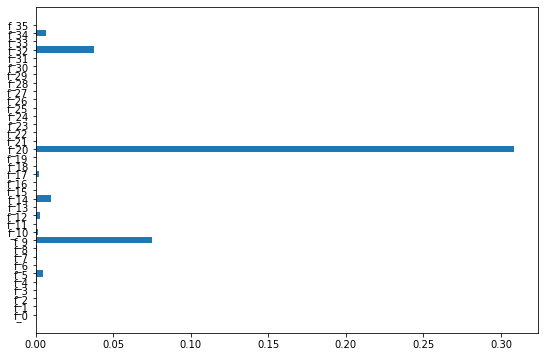

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.42761785565289945 samples from train set wiuth class balance: 0.32097560975609757


Permutation explainer: 562it [00:33,  8.34it/s]                         
Permutation explainer: 465it [00:40,  9.14it/s]                         
Permutation explainer: 314it [00:26,  8.75it/s]                         
Permutation explainer: 132it [00:11,  1.27it/s]                         
Permutation explainer: 183it [00:15,  4.18it/s]                         
Permutation explainer: 131it [00:11,  1.27s/it]                         


--- 257.19156885147095 seconds ---
IF f_20 <-1.475954532623291 THEN class = 0 # 1.0



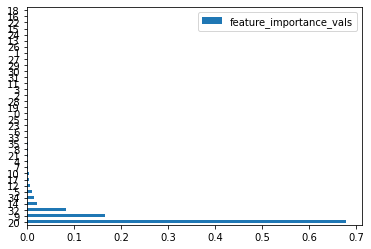

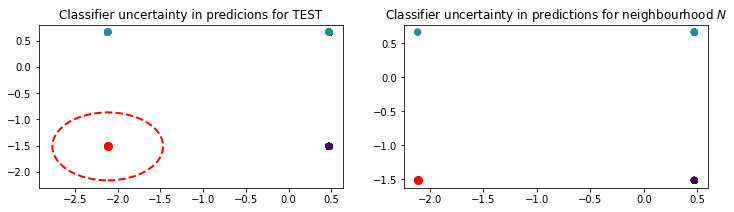

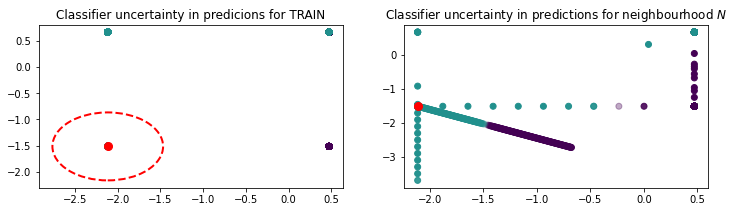

Fidelity  with shap: 0.961038961038961
f_20<-1.475954532623291
f_20<-1.475954532623291
SHAP coverage: nn: 0.22784810126582278 and local: 0.16896120150187735
Full rule: {'rule': {'f_20': ['< -1.475954532623291']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.6784673563410281
Fidelity  EXPLAN: 0.8
LORE expl e = {'f_34': ['== -0.6024116423014999'], 'f_20': ['== -2.1148528884360096']}
f_34== -0.6024116423014999 and f_20== -2.1148528884360096
f_34== -0.6024116423014999 and f_20== -2.1148528884360096
Explan coverage: nn: 0.22784810126582278 and local: 0.1376720901126408
Full rule: {'rule': {'f_34': ['== -0.6024116423014999'], 'f_20': ['== -2.1148528884360096']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN explan:0.3467919120771942
Fidelity  LORE: 0.888888888888889
LORE expl e = {'f_20': ['<-0.5643994808197021'], 'f_32': ['>=-0.41824279725551605']}
Ats lore: ['f_20', 'f_32']
f_20<-0.5643994808197021 and f_32>=-0.41824279725551605
f_20<-0.5643994808197021 and f_32>=-0.41824279725551

Permutation explainer: 456it [00:32, 10.20it/s]                         


Done 0.5362637362637362 upsampling
Done 0.9516483516483516 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35'],
      dtype='object')
Train sample size: 1132 (0.4722569879015436)


Permutation explainer: 1134it [01:18, 13.42it/s]                          


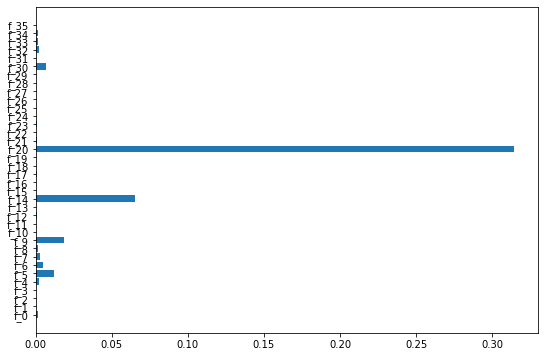

Fidelity  dectree: 1.0
Lux w shap
In fact using: 0.4722569879015436 samples from train set wiuth class balance: 0.36925795053003535


Permutation explainer: 622it [00:37, 11.48it/s]                         
Permutation explainer: 619it [00:35, 13.88it/s]                         


In [ ]:
import time
nac_data  = []
fid_data = []
imp_fid_data=[]
features_data = []
stability_data = []
hits = []
confidences =[]
times=[]
rules = []
rule_coverages = []
rule_coverages_nn = []
rule_local_fid_data_nn = []
rule_local_fid_data = []
explanation_length = []

rs=42
init_fraction=0.1
directory = './data/numerical_only/balanced'
#directory = './data/num_and_cat/balanced'
up=True
#depth = 2
SAMPLE_SIZE=50
show=False
ismpl=True
oblique=True
synthetic = False
density_sampling=False#True
radius_sampling=False#True
oversampling=True
ostr ='both'
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_NEAREST
categorical_indicator=None
node_size_limit = 2
n_jobs=-1
n_jobs_uid3=None
min_generate_samples=0.3

importance_gain_ablation=0
ats_ablation=[]
lux_conf_ablation=0
cov_ablation_nn=acc_ablation_nn=prec_ablation_nn=rec_ablation_nn=f1_ablation_nn =cov_ablation=acc_ablation=prec_ablation=rec_ablation=f1_ablation =0
time_lux_ablation=ac_score_ablation=prec_score_ablation=rec_score_ablation=f1_score_ablation=ac_score_ablation_acc=hit_lux_ablation=0
ablation_lux_elen=0
rule_lux_ablation={}
importance_gain_noproba=0
ats_no_proba=[]
lux_conf_pure=0
cov_pure= acc_pure= prec_pure= rec_pure=f1_pure  =0
cov_pure_nn= acc_pure_nn= prec_pure_nn= rec_pure_nn=f1_pure_nn  =0
time_lux_pure=ac_score_pure=prec_score_pure=rec_score_pure=f1_score_pure=ac_score_pure_acc=hit_lux_pure=0
pure_lux_elen=0
rule_lux_pure={}

importance_gain_with_proba=0
ats_with_proba=[]
lux_conf_proba=0
cov_proba= acc_proba= prec_proba= rec_proba=f1_proba  =0
cov_proba_nn= acc_proba_nn= prec_proba_nn= rec_proba_nn=f1_proba_nn  =0
time_lux_proba=ac_score_proba=prec_score_proba=rec_score_proba=f1_score_proba=ac_score_proba_acc=hit_lux_proba=0
proba_lux_elen=0
rule_lux_proba={}

UId3.PARALLEL_ENTRY_FACTOR = 1000
nf = 4
SYNTH_BREAK=12
progress = []

skip=True
for task_id in tasks:

    if use_suite:
        task = openml.tasks.get_task(task_id)
        num_and_cat = task.get_dataset().name
    else:
        num_and_cat= classification_datasets[classification_datasets['did'] == task_id]['name'].values[0]
        

    
    if num_and_cat in  ['','FOREX_eurpln-day-Close']: 
        continue
    print('Processing '+num_and_cat)
    
    try:
        rules_temp = []
        clf_basic  =MLPClassifier()#RandomForestClassifier()#GradientBoostingClassifier()#MLPClassifier()#GradientBoostingClassifier()#RandomForestClassifier(random_state=rs,n_jobs=-1)
        clf = clf_basic
        
        if use_suite:
            split = task.get_train_test_split_indices()
            data,y= task.get_X_and_y()
            Xtrain = data[split.train]
            ytrain = y[split.train]
            
            Xtest= data[split.test]
            ytest = y[split.test]
            features = [f'f_{i}' for i in range(0,data.shape[1])]
            categorical_indicator=[False]*len(features)
        else:
            dataset = openml.datasets.get_dataset(task_id)
            X, y, categorical_indicator, features = dataset.get_data(target=dataset.default_target_attribute)
            features = [re.sub(r'[^\w]', '_', s) for s in features]
            X.columns=features
            le = LabelEncoder ()
            y = le.fit_transform(y)
            for col, is_categorical in zip(X.columns, categorical_indicator):
                if is_categorical:
                    # Apply LabelEncoder to the column
                    X[col] = le.fit_transform(X[col])

            if 'Timestamp' in X.columns:
                continue
                
            Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.33)
            data=X
            if sum(categorical_indicator) > 0 :
                continue
    
        
            
        target = 'class'
        
        if synthetic: 
            if nf > SYNTH_BREAK:
                break
            #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
            X,y= sklearn.datasets.make_classification(n_samples=250*int(nf), n_features=nf+4, 
                                                  n_informative=int(nf/2), n_redundant=int(nf/4), n_repeated=0, n_clusters_per_class=int(nf/2),
                                                  n_classes=2)
            features = [f'f_{i}' for i in range(0,X.shape[1])]
            categorical_indicator=[False]*len(features)
            df = pd.DataFrame(X, columns=features)
            df[target] = y
            num_and_cat = f'n_samples={250*int(nf)};n_features={nf+4};n_informative={int(nf/2)};n_redundant={int(nf/4)};n_classes={2};n_clusters={int(nf/2)}'
            directory='synthetic'
        else:
            continuous_indicator = np.logical_not(categorical_indicator)
            df = pd.DataFrame(data,columns=features,dtype=float)
            if sum(continuous_indicator) > 0:
                sc = StandardScaler()
                df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
            df[target] = y
        
        nf+=1
        depth = len(features)
    
        missing_percentages = df.isnull().mean() * 100
    
        # Filter columns where missing values exceed 75%
        columns_to_keep = missing_percentages[missing_percentages <= 75].index
        
        # Select only the columns to keep
        df_filtered = df[columns_to_keep]
    
        features = [f for f in features if f in df_filtered.columns]
        
        df =df.dropna()
    except:
        print('Skipping due to problems in loading a dataset')
        continue

    if df.shape[1] > 50:
        print(f'Large fsize: skippp: {num_and_cat}')
        continue
    if (len(df) >10000): #(len(df) <=2000) or (len(df)>11000): #>2000:
        print('Large'+num_and_cat+' size: '+str(len(df)))
        continue
        df = df.sample(1000)

        #density_sampling=False
        fraction = init_fraction#1000.0/len(df)
    else:
        #density_sampling=True
        fraction = init_fraction
        
    print(num_and_cat)
    if df[target].nunique() > 2:
        average="micro"
    else:
        average="binary"

    progress.append(num_and_cat)
    num+=1
    
    if len(df) < 100:
        print(f'error: {num_and_cat}')
        continue

    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
    print(f'Train size: {len(train)}')
    
    processed_samples = 0
    for explain_instance in test[features].sample(SAMPLE_SIZE,random_state=rs).values:
        explain_instance=np.array(explain_instance).reshape(1,-1)  
         
        with open(f'./results/progress.txt', 'w') as fp:
            fp.write('\n'.join(progress))
            fp.write(f'Processed {processed_samples}/100')
        processed_samples +=1
        
        instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
        print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')
        
        n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
        nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
        nn.fit(test[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh= test.iloc[ids_c.ravel()]
        
        nn.fit(train[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh_tr= train.iloc[ids_c.ravel()]
        
        try:
            start_time = time.time()
            ##############for testing dectree on the bbox sample################
            lux = LUX(predict_proba = clf.predict_proba, classifier=clf,neighborhood_size=fraction,max_depth=depth,  min_samples=5,
                      oversampling_strategy=ostr,
                      node_size_limit = node_size_limit, grow_confidence_threshold = 0,min_generate_samples=min_generate_samples)
            X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                                      X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                      use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                                     representative=representative,density_sampling=density_sampling,n_jobs=-1)
            print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')
            ###################################################################
            time_lux_gen = time.time() - start_time
            #shap on this sample
            #append pint as a first element and plot force plot
            X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        except:
           print('Skipping, due to problems in creating dataset')
           continue
            
    
            
        try:
            explainer = shap.Explainer(clf,X_shap)
            if hasattr(explainer, "shap_values"):
                shap_values = explainer.shap_values(X_shap,check_additivity=False)
            else:
                shap_values = explainer(X_shap).values
                shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
            if hasattr(explainer, "expected_value"):
                expected_values = explainer.expected_value
            else:
                expected_values=[np.mean(v) for v in shap_values]
        except TypeError:
            explainer = shap.Explainer(clf.predict_proba, X_shap)
            shap_values = explainer(X_shap).values
            shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
            expected_values=[np.mean(v) for v in shap_values]


        if type(shap_values) is not list:
            shap_values = [-shap_values, shap_values]
            expected_values=[np.mean(v) for v in shap_values]

        
        plt.figure(figsize=(9,6))
        plt.barh(features ,np.abs(shap_values).mean(0)[0])
        plt.show()
        vals = np.abs(shap_values).mean(0)[0]/np.abs(shap_values).mean(0)[0].sum()
        rsv = [sv[1:] for sv in shap_values]
        
        #take N most relevant features and focus only on these when building explanations

        feature_importance = pd.DataFrame(list(zip(features,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        shapfeatures = feature_importance.head(n=10) ## see if features used in predicting the explain instance are among the top oN of shap-returned values (LOCALLY) -- do the same with global SHAP values

        data = Data.parse_dataframe(dfneigh[features+[target]],categorical=categorical_indicator+[True])
        clf_dtree = DecisionTreeClassifier(random_state=rs,max_depth=depth,criterion='entropy')
        clf_dtree.fit(train[features],clf.predict(train[features]))
        feature_importance.plot(kind='barh')
        if show:
            graph = Source(tree.export_graphviz(clf_dtree, out_file=None
               , feature_names=features, 
                filled = True,max_depth=depth))
            display(SVG(graph.pipe(format='svg')))
            
        pos_label = clf.predict(explain_instance)[0]

        dectree_score =  accuracy_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]))
        dectree_score_prec =  precision_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        dectree_score_rec =  recall_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        dectree_score_f1 =  f1_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        print(f'Fidelity  dectree: {dectree_score_f1}')
        dectree_score_acc =  accuracy_score(clf_dtree.predict(dfneigh[features]),dfneigh[target])
        
        
        nodes = np.where(1==clf_dtree.decision_path(explain_instance).todense())[1]
        features_idxs = clf_dtree.tree_.feature[nodes][:-1]
        dtree_ats = list(set(([features[i] for i in features_idxs])))
        dtree_elen = len(dtree_ats)
        
        importance_gain_dtree = shapfeatures[shapfeatures['col_name'].isin(dtree_ats)]['feature_importance_vals'].sum()/len(dtree_ats)
        
        hit_dectree = (clf_dtree.predict(explain_instance)==clf.predict(explain_instance))
        
       
        ########################################################## ###### #######################################################
        ########################################################## LUSX + SHAP #######################################################
        try:
            print('Lux w shap')
            start_time = time.time()
            lux.attributes_names=X_train_sample.columns
           
            
            y_train_sample_proba = lux.predict_proba(X_train_sample)
            hot = np.argmax(y_train_sample_proba,axis=1)
            y_train_sample = np.zeros(y_train_sample_proba.shape)
            for i in range(0,len(y_train_sample)):
                y_train_sample[i,hot[i]] = 1
            #limit features here

            
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, 
                                        classifier=lux.classifier, 
                                        discount_importance=False, depth=0,beta=1,n_jobs=n_jobs_uid3,prune=True,oblique=oblique,imp=rsv)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1, n_jobs=n_jobs_uid3,prune=True,oblique=oblique,imp=rsv)


            try:
                time_lux_shap = time.time() - start_time+time_lux_gen
                print("--- %s seconds ---" % (time_lux_shap))
    
                if show:
                    lux.uid3.tree.save_dot('tree.dot')
                    gvz=graphviz.Source.from_file('tree.dot')
                    display(gvz)
                f1,f2=get_plot_features(lux,explain_instance,all_features = features)
                plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
                plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
                #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)
            except:
                print('WARNING: Degenerated explantion, failed to get rule')


            predictions = [int(eval(x.get_name())) for x in lux.uid3.predict(data.instances)]
            ac_score_shap = accuracy_score(clf.predict(dfneigh[features]),predictions)
            prec_score_shap = precision_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            rec_score_shap = recall_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            f1_score_shap = f1_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            hit_lux_shap = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])
            print(f'Fidelity  with shap: {f1_score_shap}')
            ac_score_shap_acc = accuracy_score(dfneigh[target],predictions)

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_shap = justification_dict['rule']
            shap_lux_elen = len(justification_dict['rule'].keys())


            cov_shap, acc_shap, prec_shap, rec_shap, f1_shap = coverage_precision(rule_lux_shap, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_shap_nn, acc_shap_nn, prec_shap_nn, rec_shap_nn, f1_shap_nn = coverage_precision(rule_lux_shap, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            print(f'SHAP coverage: nn: {cov_shap_nn} and local: {cov_shap}')
            print(f'Full rule: {lux.justify(explain_instance, to_dict=True, reduce=False)[0][0]}')

            justification = lux.justify(explain_instance)[0]
            lux_conf_shap = justification.split("#")[1]
            ats_shap= list(justification_dict['rule'].keys())
            importance_gain_shap = shapfeatures[shapfeatures['col_name'].isin(ats_shap)]['feature_importance_vals'].sum()/len(ats_shap)
            print(f'SHAPGAIN LUX:{importance_gain_shap}')
        except:
           continue
        
        ########################################################## ###### #######################################################
        ########################################################## EXPLAN #######################################################
        #X_train_sample['class'] = np.argmax(y_train_sample,axis=1)
        try:
            start_time = time.time()
            myds = prepare_ds(train,discrete=categorical_indicator)
            #myds = prepare_ds(dfneigh_tr,discrete=categorical_indicator)
            X, y = myds['X'], myds['y']
            instance2explain = explain_instance.ravel()

            # EXPLAN hyper-parameters
            N_samples = 3000#n_neighbors
            tau = 250#int(n_neighbors)/len(np.unique(df[target])


            dense_samples = DataGeneration(instance2explain, clf, myds, 3000)
            # Representative data selection step
            representative_samples = DataSelection(instance2explain, clf, dense_samples, 250)
            # Data balancing step
            neighborhood_data = DataBalancing(clf, representative_samples, myds)

            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = clf.predict(Ndf[features])

            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs_uid3)

            time_explan = time.time() - start_time

            explan_y=predict_lux(uid3,dfneigh[features])
            ac_score_explan = accuracy_score(clf.predict(dfneigh[features]),explan_y)
            prec_score_explan = precision_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            rec_score_explan = recall_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            f1_score_explan = f1_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            print(f'Fidelity  EXPLAN: {f1_score_explan}')
            ac_score_explan_acc = accuracy_score(dfneigh[target],explan_y)
        

            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            

            rule_EXPLAN = justification_dict['rule']
            explan_elen = len(justification_dict['rule'].keys())
            hit_explan = clf.predict(explain_instance)==int(justification_dict['prediction'])

            print('LORE expl e = %s' % rule_EXPLAN)


            cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_EXPLAN_nn, acc_EXPLAN_nn, prec_EXPLAN_nn, rec_EXPLAN_nn, f1_EXPLAN_nn = coverage_precision(rule_EXPLAN, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            print(f'Explan coverage: nn: {cov_EXPLAN_nn} and local: {cov_EXPLAN}')
            print(f'Full rule: {lux.justify(explain_instance, to_dict=True, reduce=False)[0][0]}')
            
            ats_explan = list(justification_dict['rule'].keys())
            explan_elen = len(ats_explan)
            importance_gain_explan = shapfeatures[shapfeatures['col_name'].isin(ats_explan)]['feature_importance_vals'].sum()/len(ats_explan)
            print(f'SHAPGAIN explan:{importance_gain_explan}')
        except:
            cov_EXPLAN=acc_EXPLAN=prec_EXPLAN=rec_EXPLAN=f1_EXPLAN=explan_elen = importance_gain_explan = prec_score_explan =rec_score_explan=f1_score_explan=ac_score_explan=ac_score_explan_acc=time_explan = np.nan
            hit_explan=cov_EXPLAN_nn= acc_EXPLAN_nn= prec_EXPLAN_nn= rec_EXPLAN_nn= f1_EXPLAN_nn =np.nan
            rule_EXPLAN={}
            ats_explan=[]
        
        
        ########################################################## ###### #######################################################
        ########################################################## LORE #########################################################
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            
            Zdf,Z = generate_lore_dataset(0, X2E=X_explain, dataset=myds, blackbox=clf,ng_function=genetic_neighborhood, discrete_use_probabilities=True, continuous_function_estimation=False)
            
            datalore = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(datalore,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs_uid3)

         
            time_lore = time.time() - start_time
  
            lore_y = predict_lux(uid3,dfneigh[features])
            ac_score_lore = accuracy_score( clf.predict(dfneigh[features]),lore_y)

            prec_score_lore = precision_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            rec_score_lore = recall_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            f1_score_lore = f1_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            
            hit_lore = (clf.predict(explain_instance)==lore_y[0])
            print(f'Fidelity  LORE: {f1_score_lore}')
            ac_score_lore_acc = accuracy_score(dfneigh[target],lore_y)

            
            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_LORE = justification_dict['rule']
            lore_elen = len(justification_dict['rule'].keys())
            
            print('LORE expl e = %s' % rule_LORE)
                
            ats_lore= list(justification_dict['rule'].keys())
            print(f'Ats lore: {ats_lore}')
            cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_LORE_nn, acc_LORE_nn, prec_LORE_nn, rec_LORE_nn, f1_LORE_nn = coverage_precision(rule_LORE, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            
            print(f'LORE coverage: nn: {cov_LORE_nn} and local: {cov_LORE}')
            print(f'Full rule: {lux.justify(explain_instance, to_dict=True, reduce=False)[0][0]}')

            
            importance_gain_lore = shapfeatures[shapfeatures['col_name'].isin(ats_lore)]['feature_importance_vals'].sum()/len(ats_lore)
            print(f'SHAPGAIN lore:{importance_gain_lore}')
        except:
            cov_LORE=acc_LORE=prec_LORE=rec_LORE=f1_LORE =lore_elen = importance_gain_lore = prec_score_lore =rec_score_lore=f1_score_lore=ac_score_lore=ac_score_lore_acc=time_lore=np.nan
            cov_LORE_nn= acc_LORE_nn= prec_LORE_nn= rec_LORE_nn= f1_LORE_nn = np.nan
            rule_LORE={}
            ats_lore=[]
            hit_lore=0
            print('LORE failed...')

        
        ########################################################## ###### #######################################################
        ########################################################## ANCHOR #######################################################
        
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            #anchor_explainer = fit_anchor(myds, train[features], test[features], train[target], test[target], X_explain)
            anchor_explainer = fit_anchor(myds, train[features], train[features], train[target], train[target], X_explain)
            exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                        clf.predict, threshold=np.max([0.5]+[f for f in [prec_score_lore,prec_score_explan, prec_score_shap, prec_score_proba, prec_score_pure] if f is not np.nan]))

            time_anchor= time.time() - start_time
            anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
            ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]
            importance_gain_anchor = shapfeatures[shapfeatures['col_name'].isin(ats_anchor)]['feature_importance_vals'].sum()/len(ats_anchor)
            print(f'SHAPGAIN anchor:{importance_gain_anchor}')

            rule_Anchor_full = anchor2arule(exp_Anchor)
            rule_Anchor={}
            for i,v in rule_Anchor_full.items():
                if i in ats_anchor[:anch_depth+1]:
                    rule_Anchor[i]=[v]

            dfXExplain = build_df2explain(clf, X_explain, myds)
            cv = get_covered(rule_Anchor_full, dfXExplain.to_dict('records'), myds)
            if len(cv) != 0:
                hit_anchor = (cv[0] == 0)
            else:
                hit_anchor=0
            rule_Anchor = split_rule_conditions(rule_Anchor)
            print(f'Anchor explanation: {rule_Anchor}')
            anchor_elen = len(ats_anchor)
            cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, categorical_indicator, pos_label, class_label='class')
            cov_anchor_nn, acc_anchor_nn, prec_anchor_nn, rec_anchor_nn, f1_anchor_nn = coverage_precision(rule_Anchor, dfneigh, features, categorical_indicator, pos_label, class_label='class')

            print(f'Anchor coverage: nn: {cov_anchor_nn} and local: {cov_anchor}')
        except:
            print('Anchor failed...')
            cov_anchor=acc_anchor=prec_anchor=rec_anchor= f1_anchor=anchor_elen = hit_anchor=importance_gain_anchor=time_anchor=np.nan
            cov_anchor_nn= acc_anchor_nn= prec_anchor_nn= rec_anchor_nn= f1_anchor_nn=np.nan
            rule_Anchor={}
    

        ########################################################## ###### #######################################################
        ########################################################## ###### #######################################################
        
        
        rules.append([num_and_cat,directory,explain_instance,rule_lux_ablation, rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])
        rules_temp.append([explain_instance,clf.predict(explain_instance)[0],rule_lux_ablation,rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])

        features_data.append([num_and_cat,directory,shapfeatures['col_name'].values,ats_ablation,ats_no_proba,ats_with_proba,ats_shap,ats_explan])
        
        times.append([num_and_cat,directory,time_lux_ablation,time_lux_pure, time_lux_proba, time_lux_shap, time_explan, time_lore, time_anchor])
        
        imp_fid_data.append([num_and_cat,directory,importance_gain_dtree,importance_gain_ablation,importance_gain_noproba, importance_gain_with_proba, importance_gain_shap, importance_gain_explan,importance_gain_lore,importance_gain_anchor])
        
        hits.append([num_and_cat,directory,model_score,instance_certainty_clf,hit_dectree, hit_lux_ablation,hit_lux_pure, hit_lux_proba, hit_lux_shap, hit_explan, hit_lore, hit_anchor])
        
        confidences.append([num_and_cat,directory,model_score,instance_certainty_clf,lux_conf_ablation,lux_conf_pure, lux_conf_proba, lux_conf_shap])
        
        fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                         dectree_score,ac_score_ablation,ac_score_pure,ac_score_proba,ac_score_shap,ac_score_explan,ac_score_lore,
                        dectree_score_prec,prec_score_ablation,prec_score_pure,prec_score_proba,prec_score_shap,prec_score_explan,prec_score_lore, 
                        dectree_score_rec,rec_score_ablation,rec_score_pure,rec_score_proba,rec_score_shap,rec_score_explan,rec_score_lore,
                        dectree_score_f1,f1_score_ablation,f1_score_pure,f1_score_proba,f1_score_shap,f1_score_explan,f1_score_lore])
        nac_data.append([num_and_cat,directory,instance_certainty_clf,ac_score_ablation_acc,ac_score_pure_acc,ac_score_proba_acc,ac_score_shap_acc, model_score, dectree_score_acc,ac_score_explan_acc,ac_score_lore_acc
                         ])
        rule_coverages.append([num_and_cat,directory,model_score,instance_certainty_clf,cov_ablation,cov_pure, cov_proba, cov_shap, cov_EXPLAN, cov_LORE, cov_anchor])
        rule_local_fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                              acc_ablation,acc_pure, acc_proba, acc_shap, acc_EXPLAN, acc_LORE, acc_anchor,
                              prec_ablation,prec_pure, prec_proba, prec_shap, prec_EXPLAN, prec_LORE, prec_anchor,
                              rec_ablation,rec_pure, rec_proba, rec_shap, rec_EXPLAN, rec_LORE, rec_anchor,
                              f1_ablation,f1_pure, f1_proba, f1_shap, f1_EXPLAN, f1_LORE, f1_anchor
                             ])
        
        rule_coverages_nn.append([num_and_cat,directory,model_score,instance_certainty_clf,cov_ablation_nn,cov_pure_nn, cov_proba_nn, cov_shap_nn, cov_EXPLAN_nn, cov_LORE_nn, cov_anchor_nn])
        rule_local_fid_data_nn.append([num_and_cat,directory,model_score,instance_certainty_clf,
                              acc_ablation_nn,acc_pure_nn, acc_proba_nn, acc_shap_nn, acc_EXPLAN_nn, acc_LORE_nn, acc_anchor_nn,
                              prec_ablation_nn,prec_pure_nn, prec_proba_nn, prec_shap_nn, prec_EXPLAN_nn, prec_LORE_nn, prec_anchor_nn,
                              rec_ablation_nn,rec_pure_nn, rec_proba_nn, rec_shap_nn, rec_EXPLAN_nn, rec_LORE_nn, rec_anchor_nn,
                              f1_ablation_nn,f1_pure_nn, f1_proba_nn, f1_shap_nn, f1_EXPLAN_nn, f1_LORE_nn, f1_anchor_nn
                             ])
        
        explanation_length.append([num_and_cat,directory,model_score,instance_certainty_clf,dtree_elen, ablation_lux_elen,pure_lux_elen, proba_lux_elen, shap_lux_elen, explan_elen, lore_elen, anchor_elen])
        
    ## calculate stability here
    results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor'])
    stab_stats = [stability_stats(results_rules, rid, train, features, categorical_indicator) for rid in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']]
    stability_data.append([num_and_cat,directory]+list(np.concatenate(stab_stats)))
    
    ## save results       

## Results visualization

In [ ]:
num_and_cat

In [ ]:
data_prefix = './results/openmlx100_deep_oblique_shap_discount_4_r/'

In [ ]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','dectree_score',
                                             'ac_score_ablation','ac_score_pure','ac_score_proba','ac_score_shap',  'ac_score_explan','ac_score_lore',
                                             'dectree_score_prec','prec_score_ablation','prec_score_pure','prec_score_proba','prec_score_shap','prec_score_explan','prec_score_lore',
                        'dectree_score_rec','rec_score_ablation','rec_score_pure','rec_score_proba','rec_score_shap','rec_score_explan','rec_score_lore',
                        'dectree_score_f1','f1_score_ablation','f1_score_pure','f1_score_proba','f1_score_shap','f1_score_explan','f1_score_lore'])#.fillna(0)
results_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))
results_fid.to_csv(data_prefix+"synthx100_scores.csv",index=False)

In [ ]:
results_fid['dataset'].nunique()

In [ ]:
results_fid.isna().sum()/results_fid.shape[0]

In [ ]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid, notch=True,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_fid.groupby('dataset').mean().mean().sort_values()

In [ ]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid.groupby('dataset').mean(), notch=False,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
print('asd')

In [ ]:
results_imp_fid = pd.DataFrame(imp_fid_data,columns=['dataset','num_and_cat','importance_gain_dtree','importance_gain_ablation','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan','importance_gain_lore','importance_gain_anchor'])#.fillna(0)
#results_imp_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))    
results_imp_fid.to_csv(data_prefix+"synthx100_importance_gain.csv",index=False)

In [ ]:
#one-shot
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=False,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_imp_fid.groupby('dataset').mean().mean().sort_values()

In [ ]:
results_hits = pd.DataFrame(hits,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','hits_dectree','hits_lux_ablation','hits_lux_pure', 'hits_lux_proba', 'hits_lux_shap', 'hits_explan','hits_lore','hits_anchor'], dtype='f8')#.fillna(0)
results_hits.to_csv(data_prefix+"synthx100_hits.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_hits.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)


In [ ]:
results_times = pd.DataFrame(times,columns=['dataset','num_and_cat','time_lux_ablation','time_lux_pure', 'time_lux_proba', 'time_lux_shap', 'time_explan', 'time_lore', 'time_anchor'], dtype='f8')#.fillna(0)
results_times.to_csv(data_prefix+"synthx100_times.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_times.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)



In [ ]:
results_conf = pd.DataFrame(confidences,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','lux_conf_ablation','lux_conf_pure', 'lux_conf_proba', 'lux_conf_shap'], dtype='f8')#.fillna(0)
results_conf.to_csv(data_prefix+"synthx100_confidences.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.lineplot(data=results_conf.groupby('dataset').mean().set_index('instance_certainty_clf'),ax=ax)
plt.xticks(rotation=90)



In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_conf.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)


In [ ]:
results_rules = pd.DataFrame(rules, columns=['dataset','num_and_cat','explain_instance','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor'])#.fillna(0)
results_rules.to_csv(data_prefix+"synthx100_rules.csv",index=False)

In [ ]:
columns_fat =[['instance_mean_'+f, 'instance_std_'+f,'feature_mean_'+f, 'feature_std_'+f] for f in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']] 
columns= ['dataset','num_and_cat']+[item for sublist in columns_fat for item in sublist]
results_stab_data = pd.DataFrame(stability_data, columns=columns)
results_stab_data.to_csv(data_prefix+"synthx100_stability.csv",index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_stab_data.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_nac = pd.DataFrame(nac_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_ablation_acc','ac_score_pure_acc','ac_score_proba_acc','ac_score_shap_acc', 'model_score', 'dectree_score_acc','ac_score_explan_acc','ac_score_lore_acc'
                         ], dtype='f8')#.fillna(0)
results_nac.to_csv(data_prefix+"synthx100_nac.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_nac.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)


In [ ]:
results_rulecov = pd.DataFrame(rule_coverages,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_rulecov.to_csv(data_prefix+"synthx100_rulecov.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_rulecov.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_rulecov_nn = pd.DataFrame(rule_coverages_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_rulecov_nn.to_csv(data_prefix+"synthx100_rulecov_nn.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_rulecov_nn.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')
results_local_fid.isna().sum()/results_local_fid.shape[0]

In [ ]:
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
results_local_fid.to_csv(data_prefix+"synthx100_local_fid.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_local_fid.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_local_fid_nn = pd.DataFrame(rule_local_fid_data_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
results_local_fid_nn.to_csv(data_prefix+"synthx100_local_fid_nn.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_local_fid_nn.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
exp_elen = pd.DataFrame(explanation_length,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                            'dtree_elen', 'ablation_lux_elen','pure_lux_elen', 'proba_lux_elen', 
                                                            'shap_lux_elen', 'explan_elen', 'lore_elen', 'anchor_elen'], dtype='f8')#.dropna()#fillna(0)
exp_elen.to_csv(data_prefix+"synthx100_rulelen.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=exp_elen.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)